## Projection of cells across datasets

Scarf allows projections (aka mapping) of cells from one dataset to another. Such projection can help in  understanding how cells are related between the two datasets. Projection/mapping is a lightweight alternative to full-blown data integration which focuses on biological interpretation. In this notebook we use data from [Kang et. al.](https://www.nature.com/articles/nbt.4042). We have already preprocessed the raw count matrix to generate UMAPs and clustering of the data ([notebook here](https://github.com/parashardhapola/scarf_vignettes/blob/main/kang_et_al_processing.ipynb)). We will use two datasets from this study: control and IFN-B treated PBMCs.

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autotime

import scarf
scarf.__version__

'0.11.0'

time: 1.59 s (started: 2021-07-31 12:01:14 +02:00)


---
### 1) Fetch datasets in Zarr format

In [2]:
scarf.fetch_dataset('kang_15K_pbmc_rnaseq', save_path='scarf_datasets', as_zarr=True)
scarf.fetch_dataset('kang_14K_ifnb-pbmc_rnaseq', save_path='scarf_datasets', as_zarr=True)

INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\scarf_datasets\kang_15K_pbmc_rnaseq\data.zarr.tar.gz
INFO: Extracting Zarr file for kang_15K_pbmc_rnaseq


INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\scarf_datasets\kang_14K_ifnb-pbmc_rnaseq\data.zarr.tar.gz
INFO: Extracting Zarr file for kang_14K_ifnb-pbmc_rnaseq
time: 17.2 s (started: 2021-07-31 12:01:15 +02:00)


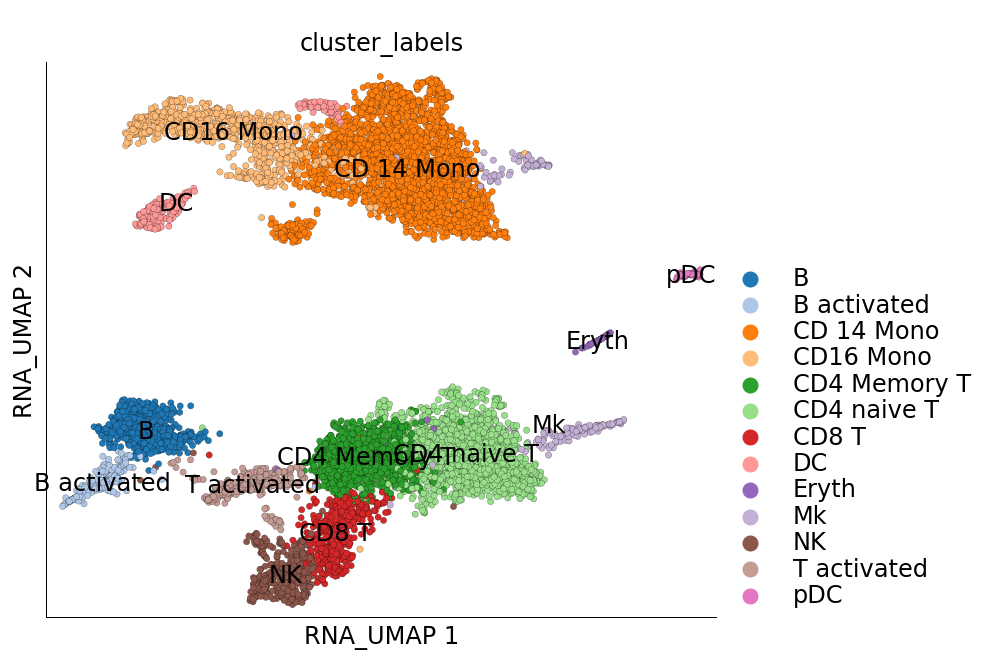

time: 1.22 s (started: 2021-07-31 12:01:32 +02:00)


In [3]:
# Control/untreated PBMC data
ds_ctrl = scarf.DataStore('scarf_datasets/kang_15K_pbmc_rnaseq/data.zarr', nthreads=4)
ds_ctrl.plot_layout(layout_key='RNA_UMAP', color_by='cluster_labels')

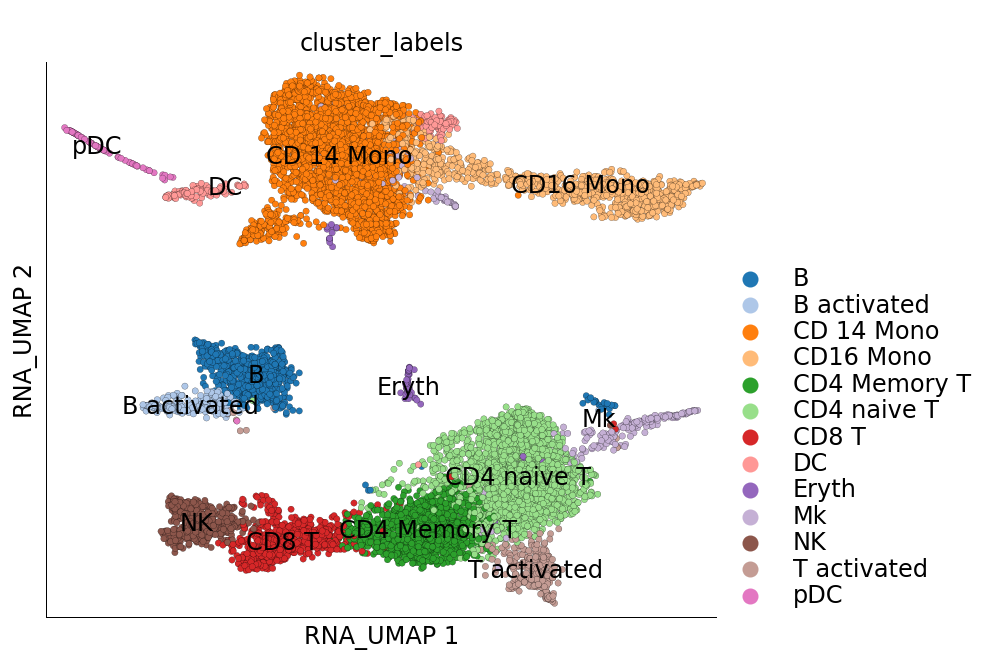

time: 547 ms (started: 2021-07-31 12:01:34 +02:00)


In [4]:
# Interferon beta stimulated PBMC data
ds_stim = scarf.DataStore('scarf_datasets/kang_14K_ifnb-pbmc_rnaseq/data.zarr', nthreads=4)
ds_stim.plot_layout(layout_key='RNA_UMAP', color_by='cluster_labels')

---
### 2) K-Nearest Neighbours (KNN) mapping

The ``run_mapping`` method of DataStore class performs KNN mapping/projection of target cells over reference cells. Reference cells are the ones that are present in the object where `run_mapping` is being called. The `Assay` object of target cells is provided as an argument to `run_mapping`. This step will load the latest graph of the reference cells and query the Approximate Nearest Neighbour (ANN) index of the reference cells for nearest neighbours of each target cell. Since the ANN index doesn't contain any target cells, nearest neighbours of target cells will exclusively be reference cells. Under the hood, `run_mapping` method makes sure that the feature order in the target cells is same as that in the reference cells. By default, `run_mapping` will impute zero values for missing features in the target order to preserve the feature order. Here we have set `run_coral` parameter to True which activates CORAL normalization of target data. CORAL aligns the the feature distribution between reference and target cells thus removing systemic difference between reference and target cells. Read more about CORAL [here](https://arxiv.org/pdf/1612.01939.pdf). Here we use control PMBCs as reference because we invoke `run_mapping` on control PBMCs' DataStore object and provide stimulated PBMC's `RNA` assay as target.

<div class="alert alert-block alert-info">
<p>
   <b>Reference cells</b>: The cells from the dataset that forms the basis of mapping. A KNN graph must already be calculated for this dataset.
</p>
<p>
    <b>Target cells</b>: The cells to be projected onto reference cells. This dataset is not required to have a graph calculated.
</p>
</div>

In [5]:
# CORAL algorithm can be very slow with large number of features (> 5000).
# Hence here it is recommended for only scRNA-Seq datasets.

ds_ctrl.run_mapping(target_assay=ds_stim.RNA, target_name='stim',
                    target_feat_key='hvgs_ctrl', save_k=5, run_coral=True)

INFO: 0 features missing in target data


Normalizing with feature subset:   0%|                                                                        …

(RNA) Writing aligned data to normed__I__hvgs_ctrl:   0%|                                                     …

INFO: Using existing normalized data with cell key I and feat key I__hvgs
INFO: Using existing loadings for pca with 25 dims
INFO: Using existing ANN index
INFO: using existing kmeans cluster centers
INFO: KNN graph already exists will not recompute.


CORAL: Computing source feature means:   0%|                                                                  …

CORAL: Computing source feature stdev:   0%|                                                                  …

CORAL: Computing target feature means:   0%|                                                                  …

CORAL: Computing target feature stdev:   0%|                                                                  …

CORAL: Computing source covariance:   0%|                                                                     …

CORAL: Computing target covariance:   0%|                                                                     …

INFO: Calculating fractional power of covariance matrices. This might take a while... 
INFO: Fractional power calculation complete


Writing out coral corrected data:   0%|                                                                       …

Mapping cells from stim:   0%|                                                                                …

time: 40.8 s (started: 2021-07-31 12:01:34 +02:00)


---
### 3) Mapping scores

We can use `mapping scores` to perform cross-dataset cluster similarity inspection. `mapping scores` are scores assigned to each reference cell based on how frequently it was identified as one of the nearest neighbour of the target cells. ``get_mapping_score`` method allows generating these scores. We use an optional parameter of `get_mapping_score`, `target_groups`. `target_groups` takes grouping information for target cells such that mapping scores are calculated for one group at a time. Here we provide the cluster information of stimulated cells as group information and mapping scores will be obtained for each target cluster independently. The UMAPs below show how much mapping score each control cell received upon mapping from cells from one of the IFN-B stimulated cell clusters.

Target cluster CD 14 Mono


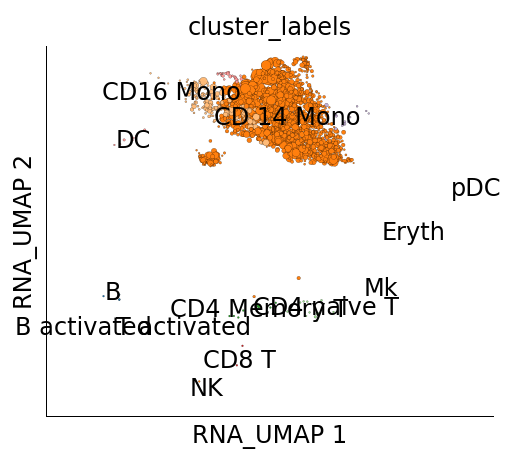

Target cluster NK


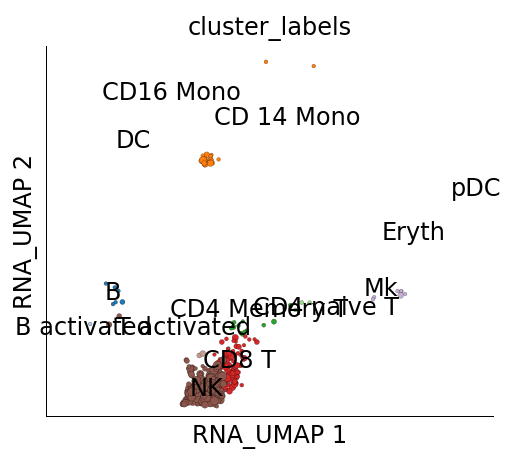

time: 484 ms (started: 2021-07-31 12:02:15 +02:00)


In [6]:
# Here we will generate plots for IFB-B stimulated cells from NK  and CD14 monocyte clusters.

for g, ms in ds_ctrl.get_mapping_score(target_name='stim',
                                       target_groups=ds_stim.cells.fetch('cluster_labels'),
                                       log_transform=True):
    if g in ['NK', 'CD 14 Mono']:
        print (f"Target cluster {g}")
        ds_ctrl.plot_layout(layout_key='RNA_UMAP', color_by='cluster_labels',
                            size_vals=ms*10, height=4, width=4, legend_onside=False)

---
### 4) Label transfer

Using the nearest neighbours of the target cells in the reference data, we can transfer labels from reference cells to target cells based on majority voting. This means that if a target cell has 'most' of its total edge weight shared with cells from one cell type, then that cell type label is tranferred to the target cell. The default threshold for 'most' is 0.5, i.e. half of all edge weight. `get_target_classes` method returns the transferred labels for each cell from a given mapped target dataset.

The `reference_class_group` parameter decides which labels to transfer. This can be any column from the cell attribute table that has categorical values, generally users would use `RNA_leiden_cluster` or `RNA_cluster` but they can also use other labels. Here, for example, we use the custom labels stored under `cluster_labels` column.

In [7]:
transferred_labels = ds_ctrl.get_target_classes(target_name='stim',
                                                reference_class_group='cluster_labels')
transferred_labels

0                  NK
1                 pDC
2         CD4 naive T
3                   B
4         CD4 naive T
             ...     
10106      CD 14 Mono
10107    CD4 Memory T
10108               B
10109      CD 14 Mono
10110     CD4 naive T
Length: 10111, dtype: object

time: 109 ms (started: 2021-07-31 12:02:16 +02:00)


We can now save these transferred labels into the stimulated cell dataset and visualize them of its UMAP.

In [8]:
ds_stim.cells.insert('transferred_labels',
                     transferred_labels.values,
                     overwrite=True)

time: 31 ms (started: 2021-07-31 12:02:16 +02:00)


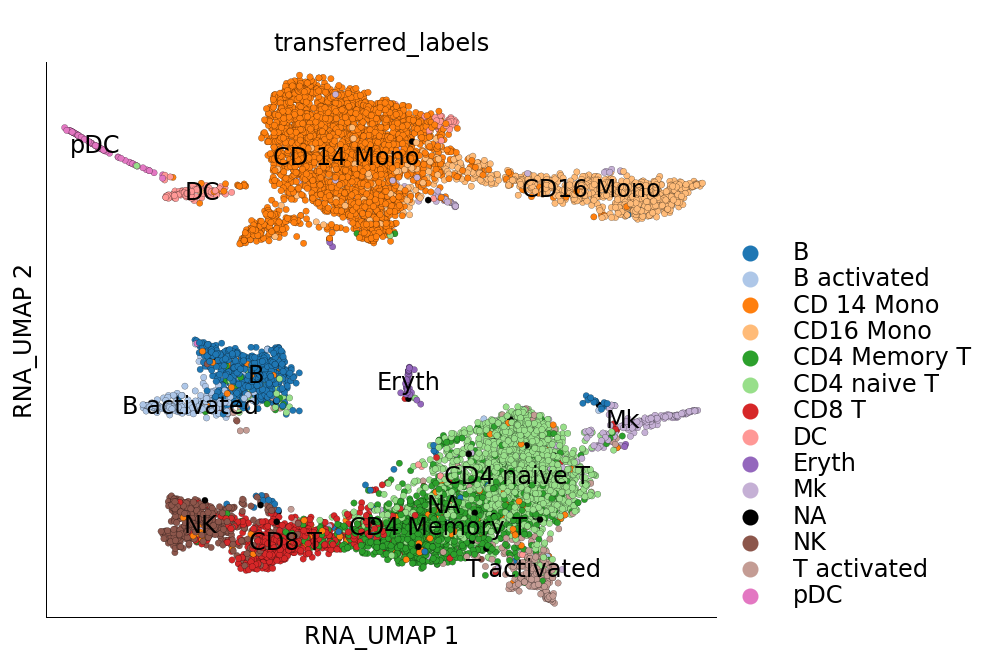

time: 641 ms (started: 2021-07-31 12:02:16 +02:00)


In [9]:
ds_stim.plot_layout(layout_key='RNA_UMAP', color_by='transferred_labels')

It can be quite interesting to check how the predicted/transferred labels compare to the actual labels of the target cells:

In [10]:
import pandas as pd

df = pd.crosstab(ds_stim.cells.fetch('cluster_labels'),
                 ds_stim.cells.fetch('transferred_labels'))
df

col_0,B,B activated,CD 14 Mono,CD16 Mono,CD4 Memory T,CD4 naive T,CD8 T,DC,Eryth,Mk,NA,NK,T activated,pDC
row_0,,,,,,,,,,,,,,
B,649,26,19,0,15,20,0,1,0,4,3,1,6,2
B activated,24,171,3,0,1,2,1,0,0,0,2,1,0,0
CD 14 Mono,0,0,2381,132,3,1,0,7,0,6,2,0,0,0
CD16 Mono,1,0,230,717,0,0,0,1,0,7,0,0,0,0
CD4 Memory T,5,0,45,1,923,217,72,0,1,5,18,0,10,0
CD4 naive T,14,4,36,0,356,1896,16,2,1,16,19,2,28,0
CD8 T,10,0,23,0,59,14,461,0,0,2,5,76,5,0
DC,0,0,73,4,0,0,0,137,0,0,0,0,0,0
Eryth,0,0,11,0,1,23,1,0,46,0,1,0,0,0


time: 47 ms (started: 2021-07-31 12:02:16 +02:00)


This cross-tabulation can be presented as percentage accuracy, where the values indicate the percentage of the transferred values that were correct.

In [11]:
(100 * df / df.sum(axis=0)).round(1)

col_0,B,B activated,CD 14 Mono,CD16 Mono,CD4 Memory T,CD4 naive T,CD8 T,DC,Eryth,Mk,NA,NK,T activated,pDC
row_0,,,,,,,,,,,,,,
B,91.8,12.9,0.7,0.0,1.1,0.9,0.0,0.6,0.0,2.1,5.9,0.2,2.2,2.9
B activated,3.4,84.7,0.1,0.0,0.1,0.1,0.2,0.0,0.0,0.0,3.9,0.2,0.0,0.0
CD 14 Mono,0.0,0.0,82.6,15.4,0.2,0.0,0.0,4.5,0.0,3.1,3.9,0.0,0.0,0.0
CD16 Mono,0.1,0.0,8.0,83.9,0.0,0.0,0.0,0.6,0.0,3.6,0.0,0.0,0.0,0.0
CD4 Memory T,0.7,0.0,1.6,0.1,65.4,9.8,12.2,0.0,2.0,2.6,35.3,0.0,3.7,0.0
CD4 naive T,2.0,2.0,1.2,0.0,25.2,85.3,2.7,1.3,2.0,8.3,37.3,0.4,10.5,0.0
CD8 T,1.4,0.0,0.8,0.0,4.2,0.6,78.1,0.0,0.0,1.0,9.8,16.6,1.9,0.0
DC,0.0,0.0,2.5,0.5,0.0,0.0,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0
Eryth,0.0,0.0,0.4,0.0,0.1,1.0,0.2,0.0,92.0,0.0,2.0,0.0,0.0,0.0


time: 31 ms (started: 2021-07-31 12:02:16 +02:00)


---
### 5) Unified UMAPs

Scarf introduces Unified UMAPs, a strategy to embed target cells onto the reference manifold. To do so, we take the results of KNN projection and spike the graph of reference cells with target cells. We can control the weight of target-reference edges also, as well as the number of edges per target to retain. We rerun UMAP on this 'unified graph' to obtain a unified embdding. Following code shows how to call `run_unified_umap` method.

In [12]:
ds_ctrl.run_unified_umap(target_names=['stim'], ini_embed_with='RNA_UMAP', target_weight=1,
                         use_k=5, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

time: 7.62 s (started: 2021-07-31 12:02:16 +02:00)


Since the results of unified embedding contain 'foreign' cells, `plot_layout` function cannot be used to visualize all the cells. A specialized method, `plot_unified_layout` takes care of this issue. The following example shows co-embedded control (reference) and stimulated  (target) PBMCs.

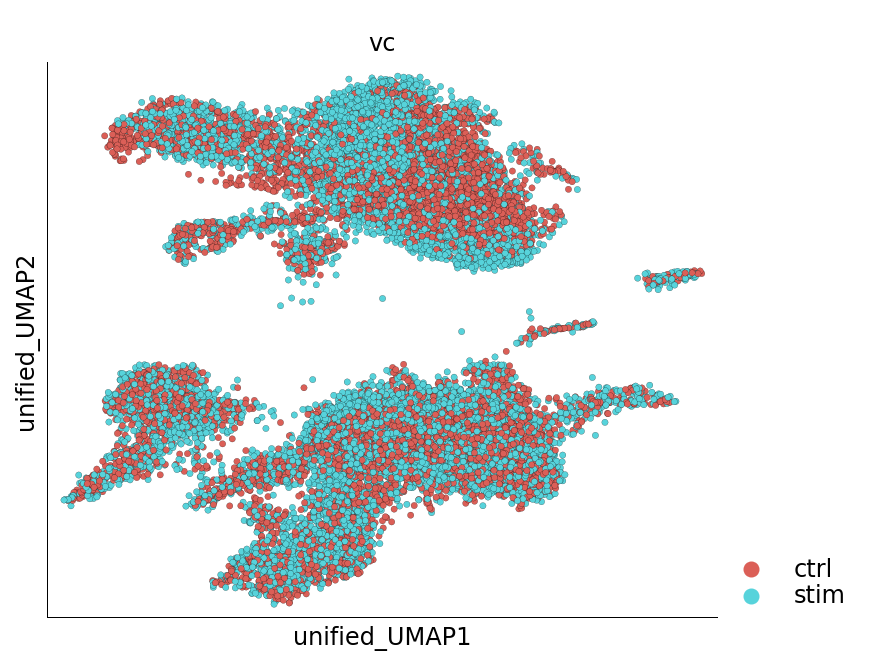

time: 500 ms (started: 2021-07-31 12:02:24 +02:00)


In [13]:
ds_ctrl.plot_unified_layout(layout_key='unified_UMAP', show_target_only=False, ref_name='ctrl')

We can visualize only the target cells, i.e IFN-B stimulated cells, in the unified embedding. The target cells can be colored based on their original cluster identity. Target cells of similar types are close together on the unified embedding and overlap with the cell types of the reference data

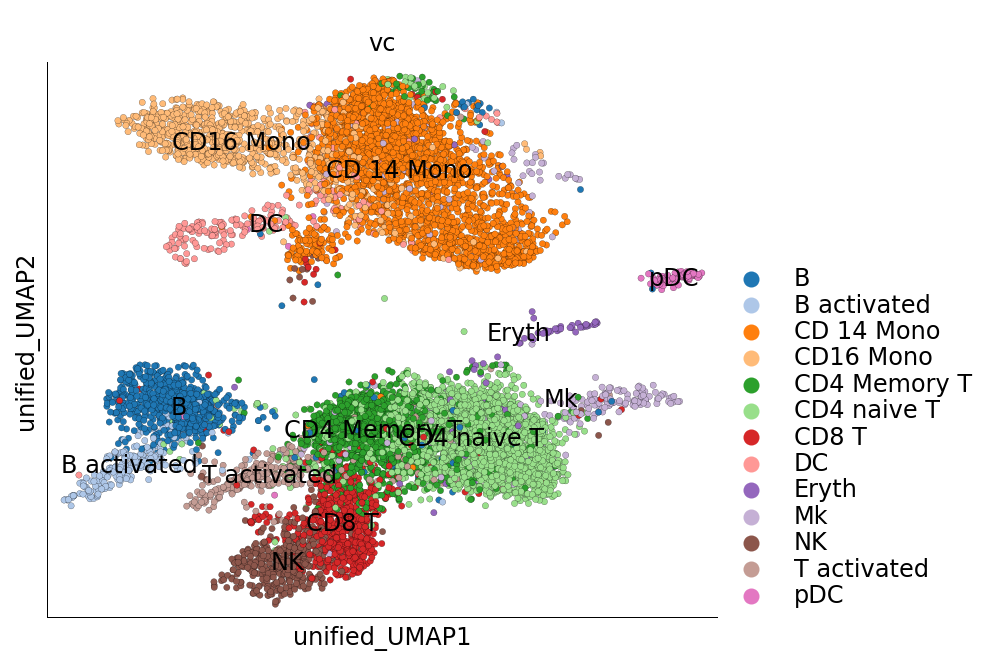

time: 547 ms (started: 2021-07-31 12:02:25 +02:00)


In [14]:
ds_ctrl.plot_unified_layout(layout_key='unified_UMAP', show_target_only=True, legend_ondata=True,
                            target_groups=ds_stim.cells.fetch('cluster_labels'))

---
That is all for this vignette.